In [1]:
# import libraries
from functools import partial
from os import path
import os
from glob import glob
from docopt import docopt
import matplotlib.pyplot as plt
import numpy as np

from sirf.Utilities import error, show_2D_array, examples_data_path
import sirf.Reg as reg
import sirf.STIR as pet
from cil.utilities.display import show2D

In [2]:
# Acquisition data stored in memory
pet.AcquisitionData.set_storage_scheme('memory')
pet.set_verbosity(0)

In [3]:
# set path to use the NEMA phantom
data_path = os.path.join( examples_data_path('PET') , 'mMR' )
os.chdir(data_path)

In [4]:
# load data
template_acq_data = pet.AcquisitionData('Siemens_mMR', span=11, max_ring_diff=15, view_mash_factor=1)
acq_data = pet.AcquisitionData('{}/sino_f1g1d0b0.hs'.format(data_path))

# random counts
rand_arr = pet.AcquisitionData('{}/sino_randoms_f1g1d0b0.hs'.format(data_path)).as_array()
rand = acq_data * 0
rand.fill(rand_arr)

# attenuation
attns = pet.ImageData('{}/mu_map.hv'.format(data_path))
asm_norm = pet.AcquisitionSensitivityModel('{}/norm.n.hdr'.format(data_path))

Reading manufacturer PET normalisation file from /home/ofn77899/devel/buildVM/INSTALL/share/SIRF-3.0/data/examples/PET/mMR/norm.n.hdr


In [5]:
# Setup image geometry
image = acq_data.create_uniform_image(0., (127, 220, 220))
image.initialise(dim=(127, 220, 220), vsize=(2.03125, 1.7080754, 1.7080754))

def get_asm_attn(sino, attn, acq_model):
    """Get attn ASM from sino, attn image and acq model."""
    asm_attn = pet.AcquisitionSensitivityModel(attn, acq_model)
    # temporary fix pending attenuation offset fix in STIR:
    # converting attenuation into 'bin efficiency'
    asm_attn.set_up(sino)
    bin_eff = pet.AcquisitionData(sino)
    bin_eff.fill(1.0)
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)
    return asm_attn

# set up the acquisition model
am = pet.AcquisitionModelUsingRayTracingMatrix()

# ASM norm already there
asm_attn = get_asm_attn(acq_data,attns,am)

# Get ASM dependent on attn and/or norm
asm = pet.AcquisitionSensitivityModel(asm_norm, asm_attn)
am.set_acquisition_sensitivity(asm)
am.set_background_term(rand)
am.set_up(acq_data, image)

In [6]:
# setup OSEM
obj_fun = pet.make_Poisson_loglikelihood(acq_data)
obj_fun.set_acquisition_model(am)

recon = pet.OSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)
recon.set_num_subsets(7)
recon.set_num_subiterations(58)
recon.set_up(image)

# set the initial image estimate
recon.set_current_estimate(image)

# run OSEM
recon.process()
osem_recon = recon.get_output()

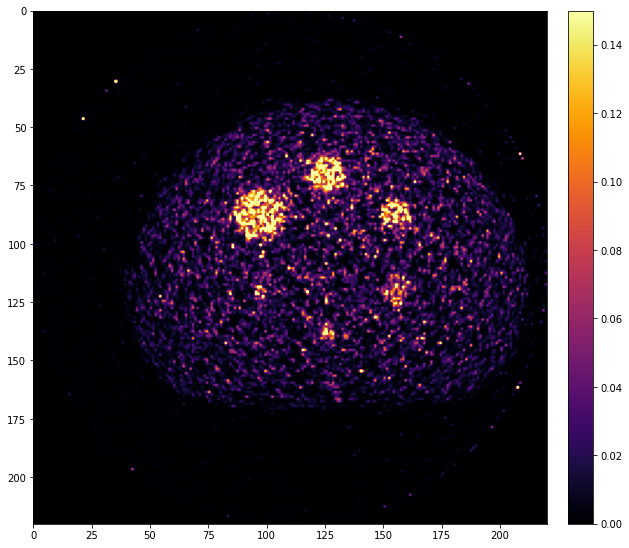

In [7]:
# show OSEM recon
show2D(osem_recon.as_array()[72,:,:], cmap="inferno", fix_range=(0,0.15), origin="upper")